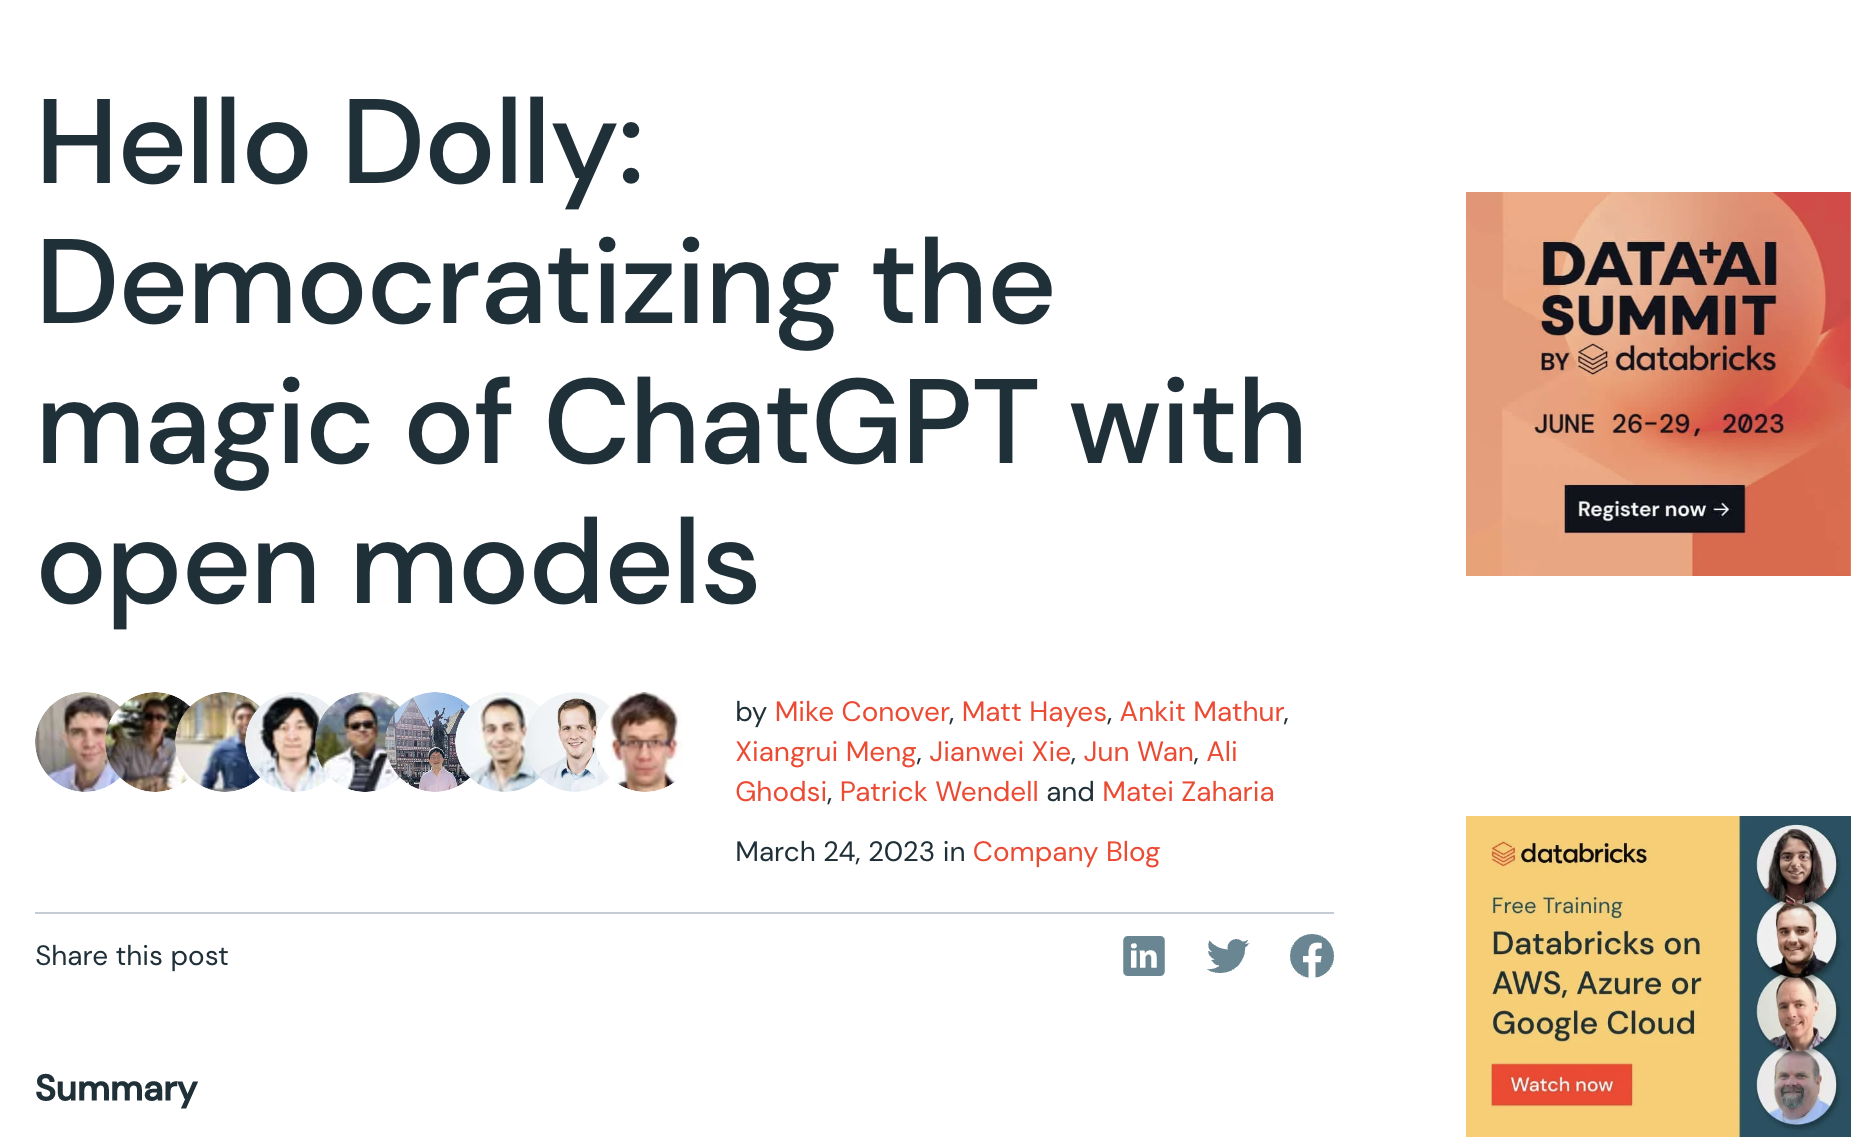

## Attempt at instruction fine-tuning DistilGPT2 for our own "Dolly Lite"

In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline, \
                         AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import Dataset, load_dataset

In [2]:
alpaca_dataset = load_dataset("tatsu-lab/alpaca")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /Users/sinanozdemir/.cache/huggingface/datasets/tatsu-lab___parquet/tatsu-lab--alpaca-2b32f0433506ef5f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
training_df = pd.DataFrame(alpaca_dataset['train'])

training_df.head()

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [4]:
# with input

In [5]:
print(training_df[training_df['input']!='']['text'].iloc[0])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Identify the odd one out.

### Input:
Twitter, Instagram, Telegram

### Response:
Telegram


In [6]:
# without input

In [7]:
print(training_df['text'].iloc[0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.


<Axes: title={'center': 'Histogram of text Length'}, ylabel='Frequency'>

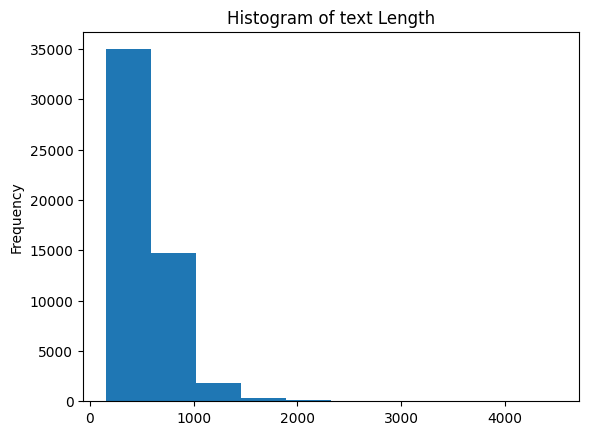

In [8]:
training_df['text'].str.len().plot(kind='hist', title='Histogram of text Length')

In [9]:
MODEL = 'distilgpt2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token


In [10]:
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

alpaca_dataset = alpaca_dataset.map(
    preprocess, batched=True, 
    remove_columns=["instruction", "input", "output", "text"]
)

split_dataset = alpaca_dataset['train'].train_test_split(test_size=0.2, seed=42)

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [11]:
split_dataset['train'][0]

{'input_ids': [21106,
  318,
  281,
  12064,
  326,
  8477,
  257,
  4876,
  13,
  19430,
  257,
  2882,
  326,
  20431,
  32543,
  262,
  2581,
  13,
  198,
  198,
  21017,
  46486,
  25,
  198,
  2061,
  318,
  262,
  27458,
  5002,
  329,
  17226,
  1271,
  1596,
  30,
  198,
  198,
  21017,
  18261,
  25,
  198,
  464,
  27458,
  5002,
  329,
  17226,
  1271,
  1596,
  318,
  609,
  4685,
  500,
  13],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [12]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 41601
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 10401
    })
})

In [13]:
# load up our model
model = AutoModelForCausalLM.from_pretrained(MODEL)

In [14]:
import numpy as np
import torch
from transformers import DataCollatorForLanguageModeling

RESPONSE_KEY = "### Response:\n"

# a custom collator which ignores the loss for everything up until ### Response:\n 
# because we really want it to be judged on it's response, not on the input prompt
class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def __call__(self, examples):
        # Fix the method name, it should be __call__, not torch_call
        batch = super().__call__(examples)

        response_token_ids = self.tokenizer.encode(RESPONSE_KEY, add_special_tokens=False)

        labels = batch["labels"].clone()

        for i in range(len(examples)):

            response_token_ids_start_idx = None
            for idx in np.where(batch["labels"][i] == response_token_ids[0])[0]:
                if np.array_equal(response_token_ids, batch["labels"][i, idx : idx + len(response_token_ids)]):
                    response_token_ids_start_idx = idx
                    break

            if response_token_ids_start_idx is None:
                raise RuntimeError("Could not find response key token IDs")

            response_token_ids_end_idx = response_token_ids_start_idx + len(response_token_ids)

            # Make pytorch loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        # Set the 'labels' field of the batch, not 'input_ids'
        batch["labels"] = labels

        return batch


In [15]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

data_collator = DataCollatorForCompletionOnlyLM(
        tokenizer=tokenizer, mlm=False
    )

In [16]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 41601
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 10401
    })
})

In [18]:
data_collator([split_dataset['train'][0], split_dataset['train'][1], split_dataset['train'][2]])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,  2061,   318,   262, 27458,  5002,   329,
         17226,  1271,  1596,    30,   198,   198, 21017, 18261,    25,   198,
           464, 27458,  5002,   329, 17226,  1271,  1596,   318,   609,  4685,
           500,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256],
       

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./gpt2_dolly_lite",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=3,  # number of training epochs
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    gradient_accumulation_steps=4,  # steps for gradient accumulation
    logging_steps=50,
    learning_rate=.001,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset['train'],
    eval_dataset=split_dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()


***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 2.781747579574585,
 'eval_runtime': 1048.9202,
 'eval_samples_per_second': 9.916,
 'eval_steps_per_second': 0.311}

In [15]:
trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 41601
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 3900


Epoch,Training Loss,Validation Loss
0,2.701600,2.545678
1,2.155100,2.413142
2,1.680200,2.406052


***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-1300
Configuration saved in ./gpt2_dolly_lite/checkpoint-1300/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-1300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-2600
Configuration saved in ./gpt2_dolly_lite/checkpoint-2600/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-2600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-3900
Configuration saved in ./gpt2_dolly_lite/checkpoint-3900/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-3900/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./gpt2_dolly_lite/checkpoint-3900 (score: 2.406051635742187

TrainOutput(global_step=3900, training_loss=2.2749537600003755, metrics={'train_runtime': 28230.0837, 'train_samples_per_second': 4.421, 'train_steps_per_second': 0.138, 'total_flos': 6755090548064256.0, 'train_loss': 2.2749537600003755, 'epoch': 3.0})

In [89]:
trainer.train()

***** Running training *****
  Num examples = 41601
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 3900


Epoch,Training Loss,Validation Loss
0,1.528900,2.406052
1,1.519300,2.406052
2,1.500000,2.406052


***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-1300
Configuration saved in ./gpt2_dolly_lite/checkpoint-1300/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-1300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-2600
Configuration saved in ./gpt2_dolly_lite/checkpoint-2600/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-2600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32
Saving model checkpoint to ./gpt2_dolly_lite/checkpoint-3900
Configuration saved in ./gpt2_dolly_lite/checkpoint-3900/config.json
Model weights saved in ./gpt2_dolly_lite/checkpoint-3900/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./gpt2_dolly_lite/checkpoint-1300 (score: 2.406051635742187

TrainOutput(global_step=3900, training_loss=1.5163988983936798, metrics={'train_runtime': 26355.0251, 'train_samples_per_second': 4.735, 'train_steps_per_second': 0.148, 'total_flos': 6761716870348800.0, 'train_loss': 1.5163988983936798, 'epoch': 3.0})

In [90]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 10401
  Batch size = 32


{'eval_loss': 2.4060516357421875,
 'eval_runtime': 939.9207,
 'eval_samples_per_second': 11.066,
 'eval_steps_per_second': 0.347,
 'epoch': 3.0}

In [91]:
trainer.save_model()

Saving model checkpoint to ./gpt2_dolly_lite
Configuration saved in ./gpt2_dolly_lite/config.json
Model weights saved in ./gpt2_dolly_lite/pytorch_model.bin


In [93]:
loaded_model = AutoModelForCausalLM.from_pretrained('./gpt2_dolly_lite')

dolly_lite = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file ./gpt2_dolly_lite/config.json
Model config GPT2Config {
  "_name_or_path": "./gpt2_dolly_lite",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dt

In [47]:
def respond(instruction, generator, _input=None, verbose=False, **options):
    if not _input:
        prompt = f'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n'
    else:
        prompt = f'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input: {_input}\n\n### Response:\n'
    if verbose:
        print(prompt)
    generated_texts = generator(
        prompt,
        num_return_sequences=3,
        temperature=options.get('temperature', 0.7),
        max_new_tokens=options.get('max_new_tokens', 128)
    )
    for generated_text in generated_texts:
        print(generated_text['generated_text'].split('### Response:\n')[1])
        print('----')


In [48]:
# Count the number of parameters
num_params = loaded_model.num_parameters()

print("Number of parameters in the loaded model:", num_params)

Number of parameters in the loaded model: 81912576


In [49]:
loaded_model = AutoModelForCausalLM.from_pretrained('./gpt2_dolly_lite')

finetuned_generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

# Dolly Lite v 0.1

In [52]:
instruction = 'What are 10 unique keywords people on twitter would have in their bio who are crypto people?'
respond(instruction, dolly_lite, verbose=True, temperature=1.)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are 10 unique keywords people on twitter would have in their bio who are crypto people?

### Response:

1. Toast
2. Cryptocurrency
3. Cryptocurrency
4. Dollar
5. Litecoin
6. Cryptocurrency
7. Crypto Assets
8. Cryptocurrency
9. Cryptocurrency
10. Crypto Assets
11. Decetations
12. Cryptocurrency
13. Cryptocurrency
14. Crypto Assets
15. Cryptocurrency
16. Cryptocurrency
17. Cryptocurrency
18. Crypto Assets
19. Cryptocurrency

19. Crypto Assets
20. Cryptocurrency
21. Crypto Assets
22. Cryptocurrency

----
1. Crypto People
2. Cryptocurrencies
3. Decentral
4. Cryptocurrency
5. Crypto Assets
6. Cryptocurrency
7. Crypto Assets
8. Crypto Assets
9. Crypto Assets
10. Crypto Assets
11. Crypto Assets
12. Crypto Assets
13. Cryptocurrency
14. Crypto Assets
15. Crypto Assets
16. Crypto Assets
17. Crypto Assets
18. Crypto Assets
19. Crypto Assets
19. Cryptocurrency
19. Crypto

In [60]:
tokenizer.encode('Neutral'), tokenizer.encode('Positive'), tokenizer.encode('Negative')

([8199, 6815], [21604, 1800], [32863, 876])

In [53]:
respond(
    'What is the sentiment of this sentence? (positive, neutral or negative)',
    dolly_lite,
    _input='Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.',
    temperature=0.01,  # I want a deterministic classifier
    verbose=True,
    max_new_tokens=2 # Negative and Positive are 2 tokens each
)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is the sentiment of this sentence? (positive, neutral or negative)

### Input: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.

### Response:

Positive
----
Positive
----
Positive
----


In [87]:
respond(
    'Write me an email to my boss, telling her I quit because I made a cool LLM.', dolly_lite
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Dear [Boss Name],

I am writing to inform you that I have decided to quit due to [reason for canceling my services] due [reason for canceling services].

I am writing to inform you that I will not be leaving the business because I had a difficult time due to [reason for canceling services].

I understand that this decision has been difficult and I believe I will be happy to do my best to make your business a success.

I look forward to hearing from you soon and may you be happy to continue to serve this position.

Sincerely,
[Your Name]
----
Dear [Boss Name], 

I am writing to inform you that I have decided to quit. I have been working hard for [insert length of time] and am looking to make a positive change. I believe that my hard work and dedication have earned me a great salary and I am looking forward to making it to the big picture.

Sincerely, 
[Name] 
[Your Name] 
[Your Name] 
[Your Name] 
[Your Name] 
[Your Name] 
[Your Name] 
[Your Name] 
[Your Name] 
----
Dear [Boss],

I'm wr

In [54]:
# slightly change the input
respond(
    'What is the sentiment of this sentence? (positive, neutral or negative)',
    dolly_lite,
    _input='Our family hates these udon type noodles, too thick and chewy. Very spicey so we only use half a pack of seasoning for each.',
    temperature=0
    verbose=True,
    max_new_tokens=2
)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is the sentiment of this sentence? (positive, neutral or negative)

### Input: Our family hates these udon type noodles, too thick and chewy. Very spicey so we only use half a pack of seasoning for each.

### Response:

Negative
----
Negative
----
Negative
----


# Non finetuned GPT2

In [61]:
non_finetuned_generator = pipeline(
    'text-generation', model=AutoModelForCausalLM.from_pretrained('distilgpt2'), tokenizer=tokenizer
)

In [63]:
instruction = 'What are 10 unique keywords people on twitter would have who are crypto people?'
respond(instruction, non_finetuned_generator, verbose=True, temperature=1.)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are 10 unique keywords people on twitter would have who are crypto people?

### Response:

It doesn't matter if someone has a job but is not actively seeking this service after paying a certain amount which can be useful because it increases your chances of getting any response.
###
----
The code below is designed and uses Twitter's API as backend and API to answer questions about whether or not we are on the right track to become crypto. If you are interested in learning more about the topic then take a look at the main section below.
http://t.co/zgqSqvL3Jt — Crypto.Rights (@cryptonrights) February 5, 2017

1. The above code is designed to identify specific keywords and provide information about where they are from, how they are coming from, how they have been accessed, what is coming and how they are working to learn more about how
----
You do not have to g

In [66]:
respond(
    'What is the sentiment of this sentence? (positive, neutral or negative)',
    non_finetuned_generator,
    _input='Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.',
    temperature=0.01,  # I want a deterministic classifier
    verbose=True,
    max_new_tokens=128 # Letting GPT2 speak more
)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is the sentiment of this sentence? (positive, neutral or negative)

### Input: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.

### Response:

This is a simple example of how to use the word "soda" in a sentence.

----
This is a simple example of how to use the word "soda" in a sentence.

----
This is a simple example of how to use the word "soda" in a sentence.

----
